# Tracking de vehicles utilitzant YOLO

El tracking o seguiment d'objectes és una tasca de visió per computador que consisteix en seguir un objecte o una regió d'interès a través de diferents fotogrames d'un vídeo. Aquesta tasca és molt important en moltes aplicacions com la vigilància, la conducció autònoma, la realitat augmentada, etc.

Nosaltres utilitzarem YOLO (You Only Look Once) per detectar els objectes en cada fotograma i després utilitzarem ByteTrack per seguir-los. ByteTrack és un algoritme de seguiment d'objectes que utilitza la informació de la detecció per seguir els objectes a través dels fotogrames. ByteTrack és molt ràpid i eficient, i pot ser utilitzat en temps real.

## Carreguem les llibreries

Comencem instal·lant i carregant les llibreries necessàries per aquest notebook.


In [47]:
%pip install ultralytics requests opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [48]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

import cv2
import matplotlib.pyplot as plt

import requests

Ultralytics YOLOv8.1.37 🚀 Python-3.8.10 torch-2.2.2+cu121 CPU (12th Gen Intel Core(TM) i3-1215U)
Setup complete ✅ (8 CPUs, 15.3 GB RAM, 89.3/219.4 GB disk)


## Dades

Per aquest projecte no caldrà entrenar un model ja que utilitzarem un model pre-entrenat de YOLO amb el dataset COCO, que conté les classes de cotxes que necessitem. Si calgés podríem repetir el procés vist en la pràctica anterior per entrenar un model amb les nostres pròpies dades.

En primer lloc, carreguem el video que volem analitzar. En aquest cas, utilitzarem un video de cotxes en una autopista.

In [1]:
!wget https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/vehicle-counting.mp4

--2024-03-29 21:24:04--  https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/vehicle-counting.mp4
S'està resolent lawer.github.io (lawer.github.io)… 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
S'està connectant a lawer.github.io (lawer.github.io)|185.199.108.153|:443… connectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 200 OK
Mida: 35345757 (34M) [video/mp4]
S'està desant a: «vehicle-counting.mp4.1»

vehicle-counting.mp 100%[===================>]  33,71M  48,1MB/s    in 0,7s    

2024-03-29 21:24:08 (48,1 MB/s) - s'ha desat «vehicle-counting.mp4.1» [35345757/35345757]



In [50]:
SOURCE_VIDEO_PATH = "vehicle-counting.mp4"

## Carreguem el model YOLO

Seguirem els passos de la pràctica anterior per carregar el model YOLO. A continuació l'executem per a obtenir les deteccions dels cotxes en un fotograma del video.

In [51]:
model = YOLO("yolov8l.pt")

In [52]:
video = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Extraiem el primer frame del vídeo

success, frame = video.read()

In [53]:
# Detectem els objectes del frame

results = model(frame)

# Mostrem els resultats

for r in results:
    for box in r.boxes:
        print(f"Coordenades de la caixa: {box.xyxy}")
        print(f"Confiança: {box.conf}")
        print(f"Classe: {box.cls}")
        print()


0: 384x640 3 cars, 1 truck, 529.3ms
Speed: 2.5ms preprocess, 529.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Coordenades de la caixa: tensor([[2942.2930, 1271.7455, 3225.4299, 1497.0488]])
Confiança: tensor([0.9016])
Classe: tensor([2.])

Coordenades de la caixa: tensor([[ 937.3493,  895.1592, 1245.1067, 1305.0732]])
Confiança: tensor([0.8946])
Classe: tensor([7.])

Coordenades de la caixa: tensor([[1437.2089, 1086.9843, 1622.6614, 1228.1613]])
Confiança: tensor([0.7979])
Classe: tensor([2.])

Coordenades de la caixa: tensor([[1477.5365, 1006.3534, 1630.9124, 1137.9227]])
Confiança: tensor([0.6360])
Classe: tensor([2.])



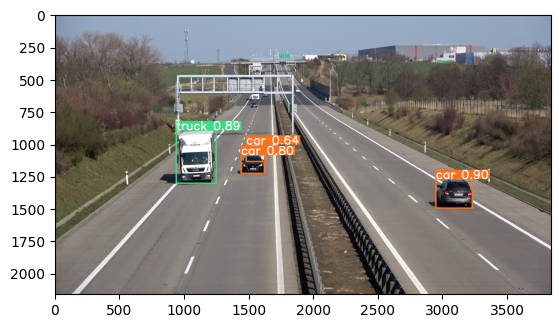

In [54]:
# Visualitzem el frame amb les caixes dels objectes detectats

for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

Els resultats son prou bons, per lo que podem continuar amb el seguiment dels cotxes.

## Seguiment de vehicles

Per fer el seguiment de vehicles utilitzarem el tracker ByteTrack. Anirem fotograma per fotograma i per cada fotograma actualitzarem el tracker amb les noves deteccions. Això ens permetrà seguir els vehicles a través del video.

In [55]:

video_in = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Llegim el primer frame del vídeo
success, frame = video_in.read()

# Creem un objecte per escriure el vídeo en format MP4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter("cotxes.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]))

while video_in.isOpened():
    success, frame = video_in.read()

    if success:
        # Utilitzem persist=True per mantenir la identitat dels objectes
        results = model.track(frame, persist=True, tracker="bytetrack.yaml")

        # Creem el frame amb les caixes dels objectes detectats
        sortida = results[0].plot()

        # Escrivim el frame al vídeo de sortida
        video_out.write(sortida)
    else:
        break

# Alliberem els recursos
video_in.release()
video_out.release()



0: 384x640 2 cars, 1 truck, 611.6ms
Speed: 3.0ms preprocess, 611.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 591.7ms
Speed: 2.5ms preprocess, 591.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 544.2ms
Speed: 2.2ms preprocess, 544.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 568.8ms
Speed: 2.4ms preprocess, 568.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 524.6ms
Speed: 5.1ms preprocess, 524.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 520.7ms
Speed: 10.7ms preprocess, 520.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 525.0ms
Speed: 8.5ms preprocess, 525.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 545.9ms
Speed: 2.8ms prep

El resultat el tenim en [`cotxes.mp4`](https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/cotxes_comprimit.mp4) que podem descarregar i visualitzar.

## Dibuxem el seguiment

Com a exemple del que es pot fer en el seguiment, dibuixarem una estela dels vehicles en el video. Això ens permetrà veure com es mouen els vehicles al llarg del video.

In [60]:

from collections import defaultdict
import numpy as np

video_in = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Llegim el primer frame del vídeo
success, frame = video_in.read()

# Creem un objecte per escriure el vídeo en format MP4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter("cotxes_estela.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]))

track_history = defaultdict(lambda: [])

while video_in.isOpened():
    success, frame = video_in.read()

    if success:
        # Utilitzem persist=True per mantenir la identitat dels objectes
        results = model.track(frame, persist=True, tracker="bytetrack.yaml")

        # Creem el frame amb les caixes dels objectes detectats
        sortida = results[0].plot()

        try:
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(sortida, [points], isClosed=False, color=(230, 230, 230), thickness=10)

        except Exception as e:
            print(e)

        # Escrivim el frame al vídeo de sortida
        video_out.write(sortida)
    else:
        break

# Alliberem els recursos
video_in.release()
video_out.release()

El resultat el tenim en [`cotxes_estela.mp4`](https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/cotxes_estela_comprimit.mp4) que podem descarregar i visualitzar.